In [1]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print
    
def init_distributed():

    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    dist_url = "env://" # default
    # only works with torch.distributed.launch // torch.run
    rank = int(os.environ["RANK"])
    world_size = int(os.environ['WORLD_SIZE'])
    local_rank = int(os.environ['LOCAL_RANK'])

    dist.init_process_group(
            backend="nccl",
            init_method=dist_url,
            world_size=world_size,
            rank=rank)

    # this will make all .cuda() calls work properly
    try:
        torch.cuda.set_device(local_rank)
    except:
        print("error at", local_rank)
    # synchronizes all the threads to reach this point before moving on
    dist.barrier()
    setup_for_distributed(rank == 0)

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import copy
import time
import math
import command
import random
import sys
import h5py

#os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'
os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'

import cv2
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 8

from skimage import img_as_ubyte
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import *
from sklearn.metrics import *

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
#import segmentation_models_pytorch_3d as smp
import timm
from torchtoolbox.tools import mixup_data, mixup_criterion
import torchvision as tv
from torch_ema import ExponentialMovingAverage

from transformers import get_cosine_schedule_with_warmup

import torch.distributed as dist

import logging
logging.getLogger('timm').setLevel(logging.WARNING)

#import redis
#import pickle
#redis_cache = redis.StrictRedis(host='localhost', port=6379, db=0)
#redis_cache.flushdb()

In [2]:
class CFG:
    DDP = 1
    DDP_INIT_DONE = 0
    N_GPUS = 2
    FOLD = 0
    FULLDATA = 0
    
    model_name = -1
    V = -1
    
    OUTPUT_FOLDER = f"./data/classification_stage1/{model_name}_v{V}"
    
    seed = 3407
    
    device = torch.device('cuda')
    
    n_folds = 4
    
    image_size = [512, 512]
    
    train_batch_size = 32
    valid_batch_size = 32
    acc_steps = 1
    
    lr = 1e-3
    wd = 1e-5
    ema_decay_per_epoch = 0.3
    freeze_epochs = 0
    n_epochs = 10
    n_warmup_steps = 0
    upscale_steps = 1.3
    validate_every = 1
    
    epoch = 0
    global_step = 0
    literal_step = 0
    
    autocast = True
    
    workers = 4

if CFG.FULLDATA:
    CFG.seed = CFG.FOLD
    
OUTPUT_FOLDER = CFG.OUTPUT_FOLDER
        
CFG.cache_dir = CFG.OUTPUT_FOLDER + f'/cache/'
os.makedirs(CFG.cache_dir, exist_ok=1)

seed_everything(CFG.seed)

In [3]:
fractured_fold_data = pd.read_csv('./data/train_stage1_foldinfo.csv')

fractured_patients = fractured_fold_data.patient.unique()

patient_to_fold = {val[0]: val[1] for val in fractured_fold_data.values}

fractured_fold_data

,patient,fold
0,1.2.826.0.1.3680043.10051,0
1,1.2.826.0.1.3680043.10579,0
2,1.2.826.0.1.3680043.10678,0
3,1.2.826.0.1.3680043.10697,0
4,1.2.826.0.1.3680043.10732,0
...,...,...
230,1.2.826.0.1.3680043.8519,3
231,1.2.826.0.1.3680043.8693,3
232,1.2.826.0.1.3680043.9447,3
233,1.2.826.0.1.3680043.9926,3


In [4]:
data = pd.read_csv(f'./data/train_stage1_F{CFG.FOLD}.csv')

data['fractured_patient'] = data.folder.apply(lambda x: 1 if x in fractured_patients else 0)

fractured_data = data[data.fractured_patient==1]
non_fractured_data = data[data.fractured_patient==0]

fractured_data['fold'] = fractured_data.folder.apply(lambda x: patient_to_fold[x])

healthy_patient_to_fold = {patient: i%4 for i, patient in enumerate(non_fractured_data.folder.unique())}
non_fractured_data['fold'] = non_fractured_data.folder.apply(lambda x: healthy_patient_to_fold[x])

data = pd.concat([fractured_data, non_fractured_data])

data

,image_path,rle_c1,rle_c2,rle_c3,rle_c4,rle_c5,rle_c6,rle_c7,rle_c8,folder,...,image_crop_x1,image_crop_y1,image_crop_x2,image_crop_y2,patient_crop_x1,patient_crop_y1,patient_crop_x2,patient_crop_y2,fractured_patient,fold
0,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(15199, 3), (15451, 7), (15705, 7), (15960, 4)]",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.345098,0.231373,0.380392,0.243137,0.172549,0.168627,0.749020,0.788235,1,0
1,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14942, 5), (15195, 9), (15448, 12), (15702, ...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.329412,0.227451,0.388235,0.254902,0.172549,0.168627,0.749020,0.788235,1,0
2,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14683, 7), (14936, 13), (15189, 17), (15443,...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.313725,0.223529,0.392157,0.262745,0.172549,0.168627,0.749020,0.788235,1,0
3,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14427, 7), (14680, 12), (14933, 17), (15187,...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.305882,0.219608,0.470588,0.266667,0.172549,0.168627,0.749020,0.788235,1,0
4,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14173, 7), (14425, 14), (14677, 18), (14931,...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.301961,0.215686,0.486275,0.270588,0.172549,0.168627,0.749020,0.788235,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109783,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],[],[],"[(20847, 2), (21103, 3), (21360, 1), (22382, 2...","[(27482, 4), (27517, 1), (27736, 7), (27771, 5...",1.2.826.0.1.3680043.10725,...,0.360784,0.321569,0.494118,0.407843,0.243137,0.278431,0.721569,0.705882,0,0
109784,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],[],[],"[(20335, 1), (20591, 2), (20847, 3), (21103, 3...","[(27227, 3), (27259, 2), (27481, 6), (27514, 5...",1.2.826.0.1.3680043.10725,...,0.364706,0.317647,0.490196,0.400000,0.243137,0.278431,0.721569,0.705882,0,0
109785,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],[],[],"[(19823, 4), (20079, 5), (20335, 5), (20590, 4...","[(26972, 4), (27002, 4), (27226, 7), (27255, 8...",1.2.826.0.1.3680043.10725,...,0.368627,0.301961,0.482353,0.392157,0.243137,0.278431,0.721569,0.705882,0,0
109786,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],[],[],"[(20082, 2), (20336, 4), (20590, 4), (20846, 4...","[(26461, 4), (26716, 7), (26745, 5), (26971, 1...",1.2.826.0.1.3680043.10725,...,0.384314,0.305882,0.474510,0.388235,0.243137,0.278431,0.721569,0.705882,0,0


In [17]:
pseudo_data = pd.read_csv('./data/train_stage1_pseudo1.csv')

unqs = data.folder.unique()
pseudo_data['unq_filt'] = pseudo_data.folder.apply(lambda x: 1 if x in unqs else 0)
pseudo_data = pseudo_data[pseudo_data.unq_filt==0].reset_index(drop=1)

pseudo_data['fractured'] = pseudo_data['prediction']

pseudo_data['fold'] = -1

pseudo_data

,image_path,rle_c1,rle_c2,rle_c3,rle_c4,rle_c5,rle_c6,rle_c7,rle_c8,folder,patient_crop_x1,patient_crop_y1,patient_crop_x2,patient_crop_y2,prediction,unq_filt,fractured,fold
0,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9083, 4), (9339, 5), (9596, 4), (9835, 3), (...","[(12680, 2), (12685, 1), (12936, 1)]",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.001847,0,0.001847,-1
1,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9083, 4), (9339, 5), (9595, 5), (9836, 4), (...","[(12169, 5), (12423, 8), (12679, 8), (12935, 8...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.003659,0,0.003659,-1
2,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9339, 4), (9596, 4), (9852, 4), (10084, 2), ...","[(11913, 4), (12167, 7), (12423, 8), (12678, 1...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.004688,0,0.004688,-1
3,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9597, 1), (9853, 1), (10084, 4), (10337, 7),...","[(11912, 5), (12167, 7), (12422, 10), (12678, ...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.007001,0,0.007001,-1
4,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9839, 1), (10083, 6), (10337, 8), (10591, 9)...","[(11658, 1), (11912, 6), (12167, 9), (12422, 1...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.038332,0,0.038332,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55904,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6264, 17), (6519, 19), (6774, 21), (7029, 22...","[(7822, 2), (8077, 5), (8333, 6), (8560, 3), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.029934,0,0.029934,-1
55905,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6265, 16), (6519, 19), (6774, 20), (7030, 20...","[(7566, 2), (7821, 4), (8077, 5), (8305, 2), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.012875,0,0.012875,-1
55906,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6275, 5), (6520, 17), (6775, 18), (7030, 19)...","[(7566, 2), (7821, 5), (8076, 7), (8305, 3), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.017681,0,0.017681,-1
55907,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6520, 7), (6530, 5), (6775, 17), (7031, 17),...","[(7565, 3), (7820, 6), (8050, 2), (8076, 7), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.007745,0,0.007745,-1


In [19]:
data = pd.concat([data, pseudo_data]).reset_index(drop=True)
data

,image_path,rle_c1,rle_c2,rle_c3,rle_c4,rle_c5,rle_c6,rle_c7,rle_c8,folder,...,image_crop_x2,image_crop_y2,patient_crop_x1,patient_crop_y1,patient_crop_x2,patient_crop_y2,fractured_patient,fold,prediction,unq_filt
0,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(15199, 3), (15451, 7), (15705, 7), (15960, 4)]",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.380392,0.243137,0.172549,0.168627,0.749020,0.788235,1.0,0,NaN,NaN
1,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14942, 5), (15195, 9), (15448, 12), (15702, ...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.388235,0.254902,0.172549,0.168627,0.749020,0.788235,1.0,0,NaN,NaN
2,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14683, 7), (14936, 13), (15189, 17), (15443,...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.392157,0.262745,0.172549,0.168627,0.749020,0.788235,1.0,0,NaN,NaN
3,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14427, 7), (14680, 12), (14933, 17), (15187,...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.470588,0.266667,0.172549,0.168627,0.749020,0.788235,1.0,0,NaN,NaN
4,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(14173, 7), (14425, 14), (14677, 18), (14931,...",[],[],[],[],[],[],[],1.2.826.0.1.3680043.10051,...,0.486275,0.270588,0.172549,0.168627,0.749020,0.788235,1.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165692,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6264, 17), (6519, 19), (6774, 21), (7029, 22...","[(7822, 2), (8077, 5), (8333, 6), (8560, 3), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,...,NaN,NaN,0.258824,0.078431,0.709804,0.384314,NaN,-1,0.029934,0.0
165693,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6265, 16), (6519, 19), (6774, 20), (7030, 20...","[(7566, 2), (7821, 4), (8077, 5), (8305, 2), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,...,NaN,NaN,0.258824,0.078431,0.709804,0.384314,NaN,-1,0.012875,0.0
165694,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6275, 5), (6520, 17), (6775, 18), (7030, 19)...","[(7566, 2), (7821, 5), (8076, 7), (8305, 3), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,...,NaN,NaN,0.258824,0.078431,0.709804,0.384314,NaN,-1,0.017681,0.0
165695,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6520, 7), (6530, 5), (6775, 17), (7031, 17),...","[(7565, 3), (7820, 6), (8050, 2), (8076, 7), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,...,NaN,NaN,0.258824,0.078431,0.709804,0.384314,NaN,-1,0.007745,0.0


In [20]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    changes = np.where(pixels[1:] != pixels[:-1])[0]
    starts = changes[::2]
    lengths = changes[1::2] - starts
    return list(zip(starts, lengths))


def rle_decode(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    if not len(rle): return mask.reshape(shape)
    
    for start, length in rle:
        mask[start:start + length] = 1
    return mask.reshape(shape)

class SpineDataset(Dataset):
    def __init__(self, data, transforms=None, is_training=False):
        self.data = data
        self.transforms = transforms
        self.is_training = is_training
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        row = self.data.iloc[i]
        folder = row.folder
        
        #if row.n_pixels > 300:
            #x1, y1, x2, y2 = row.image_crop_x1, row.image_crop_y1, row.image_crop_x2, row.image_crop_y2
        #else:
        x1, y1, x2, y2 = row.patient_crop_x1, row.patient_crop_y1, row.patient_crop_x2, row.patient_crop_y2
        
        image_path = row.image_path
        image = np.load(image_path)
        
        try:
            row_prev = self.data.iloc[i-2]
            row_next = self.data.iloc[i+2]
        except:
            row_prev = row
            row_next = row
        
        if row_prev.folder!=row.folder:
            row_prev = row
        if row_next.folder!=row.folder:
            row_next = row
        
        try: image_prev = np.load(row_prev.image_path)
        except: image_prev = image
        try: image_next = np.load(row_next.image_path)
        except: image_next = image
        
        image = np.stack([image_prev, image, image_next], -1)
        
        height, width = image.shape[:2]
        y1, y2, x1, x2 = int(height*y1), int(height*y2), int(width*x1), int(width*x2)
        
        image = image[y1:y2, x1:x2]
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']
            
            if image.dtype==torch.uint8: image = image.float() / image.max()
        
        label = torch.as_tensor([row.fractured]).float()
        
        return {
            'images': image,
            'labels': label,
            'ids': f"{image_path}"
        }

"\n_, axs = plt.subplots(1, 4, figsize=(30, 15))\naxs = axs.flatten()\nfor img, ax in zip(range(4), axs):\n    try:\n        ax.imshow(d['masks'][img][CFG.N//2][0].numpy(), cmap='gray')\n    except: pass\n#"

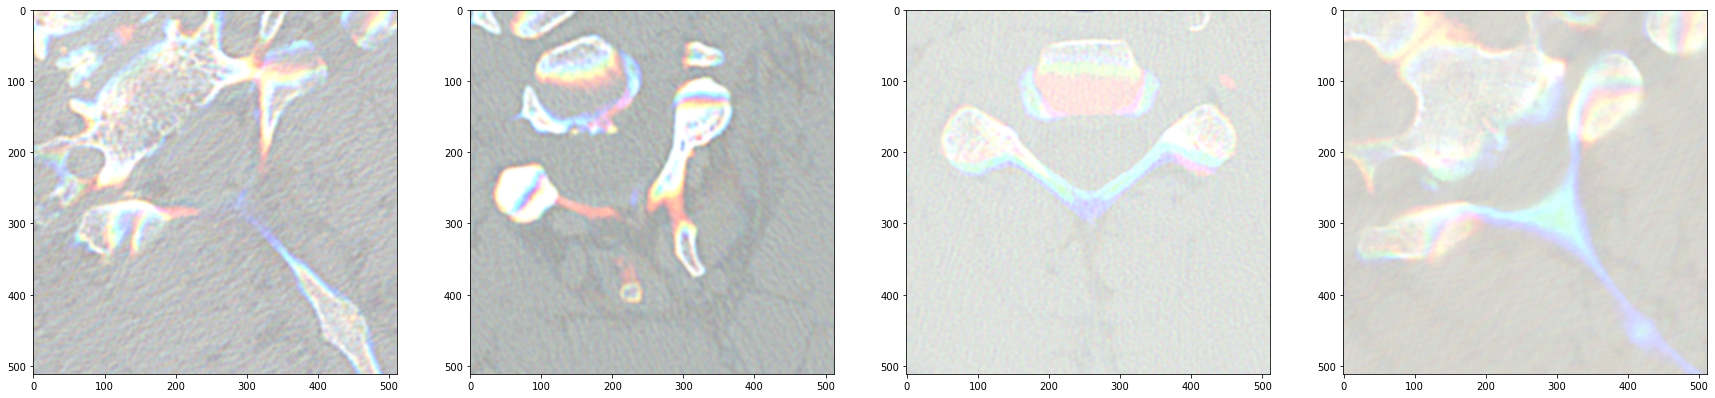

In [26]:
def get_loaders(ret_data=False, n_workers=CFG.workers):
    train_data = data[data.fold!=CFG.FOLD]
    valid_data = data[data.fold==CFG.FOLD]
    
    train_transforms = A.Compose([
        A.RandomResizedCrop(*CFG.image_size, scale=[0.8, 1.2], ratio=[0.8, 1.2]),
        #A.Resize(*CFG.image_size),
        #A.LongestMaxSize(CFG.image_size[0]),
        #A.PadIfNeeded(*CFG.image_size, border_mode=0),
        A.HorizontalFlip(p=0.5),
        A.Rotate(p=0.5, limit=45),
        ToTensorV2()
    ])

    valid_transforms = A.Compose([
        A.Resize(*CFG.image_size),
        #A.LongestMaxSize(CFG.image_size[0]),
        #A.PadIfNeeded(*CFG.image_size, border_mode=0),
        ToTensorV2()
    ])
    
    train_dataset = SpineDataset(train_data, train_transforms, 1)
    valid_dataset = SpineDataset(valid_data, valid_transforms, 0)
    
    if CFG.DDP and CFG.DDP_INIT_DONE:
        #train_sampler = torch.utils.data.WeightedRandomSampler(weights_list, len(weights_list)//CFG.N_GPUS)
        
        train_sampler = torch.utils.data.distributed.DistributedSampler(dataset=train_dataset, shuffle=True, drop_last=True)
        train_sampler.set_epoch(CFG.epoch) #needed for shuffling?
        
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, sampler=train_sampler, num_workers=CFG.workers, pin_memory=False, drop_last=True)
        
        valid_sampler = torch.utils.data.distributed.DistributedSampler(dataset=valid_dataset, shuffle=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, sampler=valid_sampler, shuffle=False, num_workers=CFG.workers, pin_memory=False)
    else:
        #train_sampler = torch.utils.data.WeightedRandomSampler(weights_list, len(weights_list))
        #train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, sampler=train_sampler, num_workers=CFG.workers, pin_memory=False)
        
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True, num_workers=n_workers, pin_memory=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=n_workers, pin_memory=False)
    
    #RUINS VALID-LOADER DDP
    #valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=False)
    
    CFG.steps_per_epoch = math.ceil(len(train_loader) / CFG.acc_steps)
    
    if ret_data:
        return train_loader, valid_loader, train_data, valid_data
    return train_loader, valid_loader
    
#train_loader, valid_loader = get_loaders(ret_data=False, n_workers=0)
train_loader, valid_loader, train_data, valid_data = get_loaders(ret_data=True, n_workers=0)

#seed_everything(42)

for d in train_loader: break
    
#_, axs = plt.subplots(2, 4, figsize=(24, 12))
_, axs = plt.subplots(1, 4, figsize=(30, 15))
axs = axs.flatten()
for img, ax in zip(range(4), axs):
    try:
        ax.imshow(d['images'][img].numpy().transpose(1,2,0), cmap='gray')
    except: pass
'''
_, axs = plt.subplots(1, 4, figsize=(30, 15))
axs = axs.flatten()
for img, ax in zip(range(4), axs):
    try:
        ax.imshow(d['masks'][img][CFG.N//2][0].numpy(), cmap='gray')
    except: pass
#'''

In [34]:
CFG.n_classes = 1

class SMPModel(nn.Module):
    def __init__(self, pretrained=True, drop=0.):
        super(SMPModel, self).__init__()
        
        segmentor = smp.Unet(encoder_name=f"tu-{CFG.model_name}", encoder_weights='imagenet', in_channels=3, classes=CFG.n_classes, aux_params={'classes': CFG.n_classes})
        self.segmentor = segmentor
        
        self.encoder = segmentor.encoder
        self.decoder = segmentor.decoder
        self.segmentation_head = segmentor.segmentation_head
        
        self.bridge = nn.Conv2d(256, 1280, kernel_size=(3, 3))
        
        feats = 1280#self.encoder.num_features
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        lstm_embed = feats
        
        self.lstm = nn.LSTM(lstm_embed, lstm_embed//2, num_layers=2, dropout=drop, bidirectional=True, batch_first=True)
        
        self.head = nn.Linear(lstm_embed, CFG.n_classes)
        
    def forward(self, inp):
        inp = torch.nan_to_num(inp, 0, 0, 0)

        bs, n_slice_per_c, in_chans, image_size, _ = inp.shape

        inp = inp.view(bs * n_slice_per_c, in_chans, image_size, image_size)

        encoded_features = self.encoder(inp)
        decoded_features = self.decoder(*encoded_features)
        masks = self.segmentation_head(decoded_features)
        
        features = encoded_features[-1]
        features = self.bridge(features)
        
        features = self.avgpool(features)
        features = features.view(bs, n_slice_per_c, -1)

        features, _ = self.lstm(features)
        features = features.contiguous().view(bs * n_slice_per_c, -1)

        logits = self.head(features)
        logits = logits.view(bs, n_slice_per_c, -1).contiguous()
        
        masks = nn.functional.interpolate(masks, (256, 256))
        
        logits = torch.nan_to_num(logits, 0, 0, 0)
        masks = torch.nan_to_num(masks, 0, 0, 0)
        
        return logits, masks
    
class TimmModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TimmModel, self).__init__()
        
        drop = 0.
        self.encoder = timm.create_model(CFG.model_name, pretrained=pretrained, in_chans=3, global_pool='', num_classes=0, drop_rate=drop, drop_path_rate=drop)
        feats = self.encoder.num_features
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.head = nn.Linear(feats, CFG.n_classes)
    
    def forward(self, inp):
        inp = torch.nan_to_num(inp, 0, 0, 0)
        
        bs, in_chans, image_size, _ = inp.shape
        
        features = self.encoder(inp)
        
        features = self.avgpool(features).flatten(1, 3)
        
        logits = self.head(features)
        
        logits = torch.nan_to_num(logits, 0, 0, 0)
        
        return logits, None
    
Model = TimmModel

In [35]:
if CFG.model_name==-1: CFG.model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'

#CFG.model_name = 'maxvit_rmlp_tiny_rw_256.sw_in1k'
#CFG.model_name = 'coat_lite_medium_384.in1k'
#CFG.model_name = 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k'

#'''
model = Model()

model.eval()

#t = time.time()
with torch.no_grad():
    outs = model(d['images'][:2])
#print(time.time() - t)
_ = [print(o.shape) for o in outs if o!=None]
#'''

torch.Size([2, 1])


In [36]:
device = torch.device('cpu')
# change it to nn.BCELoss(reduction='none') if you have sigmoid activation in last layer
loss_fn = nn.BCELoss(reduction="none") 

competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1, 7], dtype=torch.float, device=device),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2, 14], dtype=torch.float, device=device),
}

def competiton_loss(y_hat, y):
    loss = loss_fn(y_hat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1).mean()

    return loss / weights.sum()

def competiton_loss_row_norm(y_hat, y):
    y_hat, y = torch.as_tensor(y_hat.astype(np.float32)), torch.as_tensor(y.astype(np.float32))
    loss = loss_fn(y_hat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1)
    w_sum = weights.sum(axis=1)
    loss = torch.div(loss, w_sum)
    return loss.mean()
    
def calculate_competition_metric(OUTPUTS, TARGETS, IDS):
    groups = np.array([x.split('_')[0] for x in IDS])
    unqs = np.unique(groups)

    gt_df = {col: [] for col in ['StudyInstanceUID'] + [f"C{c}" for c in range(1,8)]}
    pred_df = {col: [] for col in ['StudyInstanceUID'] + [f"C{c}" for c in range(1,8)]}

    predictions, labels = [], []
    for group in unqs:

        #prediction = np.concatenate(OUTPUTS3[groups==group])[:, 1].max(0)
        #label = data_master[data_master.StudyInstanceUID==group].values[0][-7:].astype(np.float32)
        prediction = OUTPUTS[groups==group].max(1)[:, 1]
        label = TARGETS[groups==group].max(1)[:, 1]#np.concatenate(TARGETS3[groups==group])[:, 1].max(0)

        predictions.append(prediction)
        labels.append(label)

        gt_df['StudyInstanceUID'].append(group)
        for C in range(1,8):
            try:
                gt_df[f'C{C}'].append(label[C-1])
            except:
                gt_df[f'C{C}'].append(0.)
            
        pred_df['StudyInstanceUID'].append(group)
        for C in range(1,8):
            try:
                pred_df[f'C{C}'].append(prediction[C-1])
            except:
                pred_df[f'C{C}'].append(prediction.mean())
            
        #break

    pred_df, gt_df = pd.DataFrame(pred_df), pd.DataFrame(gt_df)
    pred_df['patient_overall'] = pred_df.values[:, 1:].max(1)
    gt_df['patient_overall'] = gt_df.values[:, 1:].max(1)
    
    preds = pred_df.values[:, 1:]
    labels = gt_df.values[:, 1:]

    preds[:, :7] = np.clip(preds[:, :7], 0, 0.99)
    preds[:, -1] = np.clip(preds[:, -1], 0, 0.99)

    return competiton_loss_row_norm(preds, labels)

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.as_tensor([1.]).cuda())
        self.dice = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)
        
    def forward(self, outputs=None, targets=None, outputs_masks=None, targets_masks=None):
        loss = 0.
        
        #print(outputs.shape, targets.shape, outputs_masks.shape, targets_masks.shape)
        
        if outputs_masks!=None:
            loss1 = self.dice(outputs_masks, targets_masks.flatten(0,1))
            loss = loss + loss1
        if outputs!=None:
            loss2 = self.bce(outputs, targets)
            loss = loss + loss2
        
        return loss

def plot_lr():
    m = nn.Linear(2, 1)
    optimizer = optim.AdamW(m.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_training_steps=CFG.steps_per_epoch * CFG.n_epochs * CFG.upscale_steps, num_warmup_steps=CFG.n_warmup_steps)
    
    lrs = []
    for s in range(int(CFG.n_epochs*CFG.steps_per_epoch*CFG.upscale_steps)):
        lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        lrs.append(lr)
        if s==CFG.n_epochs*CFG.steps_per_epoch:
            break
    return lrs
    
def define_criterion_optimizer_scheduler_scaler(model):
    criterion = CustomLoss().cuda()
    
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    
    ema_decay_per_iter = CFG.ema_decay_per_epoch ** (1 / CFG.steps_per_epoch)
    ema = ExponentialMovingAverage(model.parameters(), decay=ema_decay_per_iter)
    
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_training_steps=CFG.steps_per_epoch * CFG.n_epochs * CFG.upscale_steps, num_warmup_steps=CFG.n_warmup_steps)
    
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.autocast)
    
    return criterion, optimizer, scheduler, scaler, ema

In [37]:
def train_one_epoch(model, loader, running_dist=True):
    model.train()
    running_loss = 0.0

    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    for step, data in enumerate(bar):
        step += 1
        
        images = data['images'].cuda()
        targets = data['labels'].cuda()
        targets_masks = None #data['masks'].cuda()
        
        with torch.cuda.amp.autocast(enabled=CFG.autocast, dtype=torch.float16):
            logits, logits_masks = model(images)
            
            loss = criterion(logits, targets, logits_masks, targets_masks)
        
        running_loss += (loss - running_loss) * (1 / step)
        
        loss = loss / CFG.acc_steps
        scaler.scale(loss).backward()
        
        if step % CFG.acc_steps == 0 or step == len(bar):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            ema.update()
            CFG.global_step += 1
        
        CFG.literal_step += 1
        
        lr = "{:2e}".format(optimizer.param_groups[0]['lr'])
        
        if is_main_process():
            bar.set_postfix(loss=running_loss.item(), lr=float(lr), step=CFG.global_step)
            #bar.text(f" | loss={running_loss.item():.4f}, lr={lr:.6f}, step={CFG.global_step}")
        
        if running_dist:
            dist.barrier()
        
        #if step==10: break
    
    if is_main_process():
        if running_dist:
            torch.save(model.module.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}.pth")
            
        else:
            torch.save(model.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}.pth")
        
        
def valid_one_epoch(path, loader, running_dist=True, debug=False, do_ema=True):
    #model = Model(pretrained=False)
    #st = torch.load(path, map_location=f"cpu")
    model.eval()
    model.cuda()
    #model.load_state_dict(st, strict=False)
    
    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    running_loss = 0.
    
    OUTPUTS, TARGETS, IDS = [], [], []
    
    for step, data in enumerate(bar):
        
        with torch.no_grad():
            images = data['images'].cuda()
            targets = data['labels'].cuda()
            targets_masks = None#data['masks'].cuda()
            ids = data['ids']
            
            with torch.cuda.amp.autocast(enabled=CFG.autocast):
                if do_ema:
                    with ema.average_parameters():
                        logits, logits_mask = model(images)
                else:
                    logits, logits_mask = model(images)
                
            outputs = logits.float().sigmoid().detach().cpu().numpy()
            targets = targets.float().detach().cpu().numpy()
            #outputs = logits_mask.float().sigmoid().detach().cpu().numpy()
            #targets = targets_masks.float().detach().cpu().numpy()
            
            #'''
            if running_dist:
                dist.barrier()
                
                np.save(f'{CFG.cache_dir}/preds_{get_rank()}.npy', outputs)
                np.save(f'{CFG.cache_dir}/targets_{get_rank()}.npy', targets)
                np.save(f'{CFG.cache_dir}/ids_{get_rank()}.npy', ids)
                
                dist.barrier()
                
                if is_main_process():
                    outputs = np.concatenate([np.load(f"{CFG.cache_dir}/preds_{_}.npy") for _ in range(CFG.N_GPUS)])
                    targets = np.concatenate([np.load(f"{CFG.cache_dir}/targets_{_}.npy") for _ in range(CFG.N_GPUS)])
                    ids = np.concatenate([np.load(f"{CFG.cache_dir}/ids_{_}.npy") for _ in range(CFG.N_GPUS)])
                    
                dist.barrier()
            else:    
                pass
            
            OUTPUTS.extend(outputs)
            TARGETS.extend(targets)
            IDS.extend(ids)
            #'''
            
            #outputs = np.concatenate(outputs.transpose(0, 4, 1, 2, 3), 0)
            #targets = np.concatenate(targets.transpose(0, 4, 1, 2, 3), 0)
            
            #PixelLevelF1Scorer.accumulate(outputs, targets)
            
            #if step==10: break
            
    if running_dist:
        dist.barrier()
    
    if is_main_process():
        OUTPUTS = np.stack(OUTPUTS)#[:, :6]
        TARGETS = np.stack(TARGETS)#[:, :6]
        IDS = np.stack(IDS)
        
        #return OUTPUTS, TARGETS, IDS
        
        #score = PixelLevelF1Scorer.calculate_score()
        #score, classwise = DiceScorer.calculate_score()
        
        score = roc_auc_score(TARGETS, OUTPUTS)
        
        print(f"EPOCH {CFG.epoch+1} | AUC {score}")
        #print(classwise)
        
        if debug:
            return score, OUTPUTS, TARGETS, IDS
    
        return score
    
    if debug:
        return [], [], [], []
    
def run(model, get_loaders):
    if is_main_process():
        epochs = []
        scores = []
    
    best_score = float('-inf')
    for epoch in range(CFG.n_epochs):
        CFG.epoch = epoch
        
        train_loader, valid_loader = get_loaders()
        
        '''
        if CFG.epoch<CFG.freeze_epochs:
            for param in model.module.parameters():
                param.requires_grad = False
        else:
            for param in model.module.parameters():
                param.requires_grad = True
        #'''
        
        train_one_epoch(model, train_loader, running_dist=CFG.DDP_INIT_DONE)
        
        if CFG.DDP_INIT_DONE:
            dist.barrier()
        
        if (CFG.epoch+1)%CFG.validate_every==0 or epoch==0:
            if is_main_process():
                with ema.average_parameters():
                    torch.save(model.module.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}_EMA.pth")
                    
            if CFG.DDP_INIT_DONE:
                dist.barrier()
                
            #score, OUTPUTS, TARGETS, IDS  = valid_one_epoch(f"{OUTPUT_FOLDER}/{CFG.FOLD}_EMA.pth", valid_loader, debug=True, running_dist=CFG.DDP_INIT_DONE)
            score = valid_one_epoch(f"{OUTPUT_FOLDER}/{CFG.FOLD}_EMA.pth", valid_loader, debug=False, running_dist=CFG.DDP_INIT_DONE)
            
        if CFG.DDP_INIT_DONE:
            dist.barrier()
        
        if is_main_process():
            epochs.append(epoch)
            scores.append(score)
            
            if score >= best_score:
                print("SAVING BEST!")
                if CFG.DDP_INIT_DONE:
                    with ema.average_parameters():
                        torch.save(model.module.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}_best.pth")
                else:
                    with ema.average_parameters():
                        torch.save(model.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}_best.pth")
                    
                best_score = score
                
                #np.save(f"{OUTPUT_FOLDER}/OUTPUTS_{CFG.FOLD}.npy", OUTPUTS)
                #np.save(f"{OUTPUT_FOLDER}/TARGETS_{CFG.FOLD}.npy", TARGETS)
                #np.save(f"{OUTPUT_FOLDER}/IDS_{CFG.FOLD}.npy", IDS)                
            
            try:
                command.run(['rm', '-r', CFG.cache_dir])
                pass
            except:
                pass
            
            os.makedirs(CFG.cache_dir, exist_ok=1)

In [ ]:
CFG.DDP = 1

if __name__ == '__main__' and CFG.DDP:
    
    world_size = init_distributed()
    CFG.DDP_INIT_DONE = 1
    
    #important to setup before defining scheduler to establish the correct number of steps per epoch
    train_loader, valid_loader = get_loaders()
    
    model = Model().cuda()
    
    #st = torch.load(f'./data/classification_stage1/tf_efficientnetv2_s.in21k_ft_in1k_v6/{CFG.FOLD}_best.pth')
    #for key in ['head.weight', 'head.bias']: del st[key]
    #model.load_state_dict(st, strict=False)
    
    #if is_main_process():
        #torch.save(model.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}.pth")
        
    #model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
    
    local_rank = int(os.environ['LOCAL_RANK'])
    
    model = nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], find_unused_parameters=True)
    
    #model = torch.compile(model)
    
    criterion, optimizer, scheduler, scaler, ema = define_criterion_optimizer_scheduler_scaler(model)
    
    run(model, get_loaders)
    
else:
    
    CFG.DDP_INIT_DONE = False
    #important to setup before defining scheduler to establish the correct number of steps per epoch
    train_loader, valid_loader = get_loaders()
    
    model = Model().cuda()
    
    #model.load_state_dict(torch.load(f"/mnt/md0/rsna_spine/AAA_CLS/TRY12_CLS/b5_v1/best_f{CFG.FOLD}.pth", map_location='cpu'), strict=False)
    
    criterion, optimizer, scheduler, scaler = define_criterion_optimizer_scheduler_scaler(model)
    
    run(model, get_loaders)
    
import sys
sys.exit(0)

In [130]:
model = Model()
st = torch.load('./data/classification_stage1/tf_efficientnetv2_s.in21k_ft_in1k_v6/0_best.pth')
model.load_state_dict(st)

<All keys matched successfully>

In [132]:
OUTPUTS, TARGETS, IDS = [], [], []

for F in range(4):
    CFG.FOLD = F
    
    model = Model()
    st = torch.load(f'./data/classification_stage1/tf_efficientnetv2_s.in21k_ft_in1k_v6/{F}_best.pth')
    model.load_state_dict(st)
    
    train_loader, valid_loader = get_loaders(n_workers=4)
    score, outputs, targets, ids = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False, debug=True)
    
    OUTPUTS.extend(outputs)
    TARGETS.extend(targets)
    IDS.extend(ids)
    
    break

OUTPUTS, TARGETS, IDS = np.stack(OUTPUTS), np.stack(TARGETS), np.stack(IDS)
OUTPUTS.shape, TARGETS.shape, IDS.shape

851/851 01:32<00:00 


EPOCH 1 | AUC 0.8718705010548227


((27228, 1), (27228, 1), (27228,))

In [148]:
outputs = OUTPUTS[:207]
targets = TARGETS[:207]
ids = IDS[:207]

In [193]:
ids[102:118]

array(['./data/train_images_npy/1.2.826.0.1.3680043.10051/134.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/135.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/136.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/137.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/138.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/139.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/140.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/141.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/142.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/143.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/144.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/145.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/146.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/147.npy',
       './data/train_images_npy/1.2.826.0.1.3680

In [196]:
np.round(outputs[102:118], 3)

array([[0.   ],
       [0.   ],
       [0.001],
       [0.014],
       [0.023],
       [0.307],
       [0.097],
       [0.038],
       [0.   ],
       [0.085],
       [0.929],
       [0.923],
       [0.863],
       [0.054],
       [0.001],
       [0.002]], dtype=float32)

In [185]:
ids[targets[:, 0]==1]

array(['./data/train_images_npy/1.2.826.0.1.3680043.10051/134.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/135.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/136.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/137.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/138.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/139.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/140.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/141.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/142.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/143.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/144.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/145.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/146.npy',
       './data/train_images_npy/1.2.826.0.1.3680043.10051/147.npy',
       './data/train_images_npy/1.2.826.0.1.3680

In [1476]:
groups = np.array([x.split('_')[0] for x in IDS])
unqs = np.unique(groups)

gt_df = {col: [] for col in ['StudyInstanceUID'] + [f"C{c}" for c in range(1,8)]}
pred_df = {col: [] for col in ['StudyInstanceUID'] + [f"C{c}" for c in range(1,8)]}

predictions, labels = [], []
for group in unqs:
    
    #prediction = np.concatenate(OUTPUTS3[groups==group])[:, 1].max(0)
    #label = data_master[data_master.StudyInstanceUID==group].values[0][-7:].astype(np.float32)
    prediction = OUTPUTS[groups==group].max(1)[:, 1]
    label = TARGETS[groups==group].max(1)[:, 1]#np.concatenate(TARGETS3[groups==group])[:, 1].max(0)
    
    predictions.append(prediction)
    labels.append(label)
    
    gt_df['StudyInstanceUID'].append(group)
    for C in range(1,8):
        try:
            gt_df[f'C{C}'].append(label[C-1])
        except:
            gt_df[f'C{C}'].append(label[0])
    
    pred_df['StudyInstanceUID'].append(group)
    for C in range(1,8):
        try:
            pred_df[f'C{C}'].append(prediction[C-1])
        except:
            pred_df[f'C{C}'].append(prediction.mean())
        
    #break

pred_df, gt_df = pd.DataFrame(pred_df), pd.DataFrame(gt_df)
pred_df['patient_overall'] = pred_df.values[:, 1:].max(1)
gt_df['patient_overall'] = gt_df.values[:, 1:].max(1)

In [1477]:
pred_df

,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,patient_overall
0,1.2.826.0.1.3680043.10001,0.014118,0.023331,0.168036,0.027066,0.090574,0.046725,0.390127,0.390127
1,1.2.826.0.1.3680043.10005,0.248170,0.061876,0.040922,0.093182,0.341692,0.203708,0.192236,0.341692
2,1.2.826.0.1.3680043.10014,0.012147,0.024054,0.023109,0.100348,0.507434,0.028653,0.066085,0.507434
3,1.2.826.0.1.3680043.10016,0.021698,0.024423,0.013172,0.023065,0.041618,0.034294,0.052328,0.052328
4,1.2.826.0.1.3680043.10032,0.014337,0.016091,0.017442,0.038683,0.269422,0.119923,0.178383,0.269422
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.9926,0.238107,0.948632,0.049405,0.067670,0.174270,0.070560,0.103205,0.948632
2015,1.2.826.0.1.3680043.9940,0.016785,0.051654,0.017712,0.053601,0.032101,0.074500,0.124001,0.124001
2016,1.2.826.0.1.3680043.9994,0.019124,0.015845,0.018090,0.038178,0.091058,0.135690,0.086323,0.13569
2017,1.2.826.0.1.3680043.9996,0.651355,0.122418,0.016593,0.156491,0.021085,0.033972,0.064653,0.651355


In [1478]:
gt_df

,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,patient_overall
0,1.2.826.0.1.3680043.10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.2.826.0.1.3680043.10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.2.826.0.1.3680043.10014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.2.826.0.1.3680043.10016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.2.826.0.1.3680043.10032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.9926,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2015,1.2.826.0.1.3680043.9940,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2016,1.2.826.0.1.3680043.9994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017,1.2.826.0.1.3680043.9996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1479]:
for C in range(1,8):
    print(C, pred_df[gt_df[f'C{C}']==1][f"C{C}"].mean(), pred_df[gt_df[f'C{C}']==0][f"C{C}"].mean())

1 0.66991603 0.091509424
2 0.69023275 0.09471284
3 0.35932362 0.059247844
4 0.47487321 0.070726685
5 0.48910898 0.09777032
6 0.5575611 0.1452752
7 0.62278986 0.18636699


In [1480]:
device = torch.device('cpu')
# change it to nn.BCELoss(reduction='none') if you have sigmoid activation in last layer
loss_fn = nn.BCELoss(reduction="none") 

competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1, 7], dtype=torch.float, device=device),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2, 14], dtype=torch.float, device=device),
}

def competiton_loss(y_hat, y):
    loss = loss_fn(y_hat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1).mean()

    return loss / weights.sum()

def competiton_loss_row_norm(y_hat, y):
    y_hat, y = torch.as_tensor(y_hat.astype(np.float32)), torch.as_tensor(y.astype(np.float32))
    loss = loss_fn(y_hat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1)
    w_sum = weights.sum(axis=1)
    loss = torch.div(loss, w_sum)
    return loss.mean()

In [1483]:
preds = pred_df.values[:, 1:].copy()
labels = gt_df.values[:, 1:].copy()

preds[:, :7] = np.clip(preds[:, :7] * 1., 0., 0.99)
preds[:, -1] = np.clip(preds[:, -1] * 1., 0., 0.99)

competiton_loss_row_norm(preds, labels)

tensor(0.3601)

In [1217]:
preds = pred_df.values[:, 1:].copy()
labels = gt_df.values[:, 1:].copy()

preds[:, :7] = np.clip(preds[:, :7] * 1., 0., 0.99)
preds[:, -1] = np.clip(preds[:, -1] * 1., 0., 1.)

competiton_loss_row_norm(preds, labels)

tensor(0.3684)

In [832]:
np.sum(gt_df.patient_overall==(pred_df.patient_overall>0.2)) / len(gt_df)

0.7465346534653465

In [730]:
roc_auc_score(labels, predictions)

0.7915564582152528

In [736]:
predictions[labels==1].mean(), predictions[labels==0].mean()

(0.4405179, 0.09554876)

In [582]:
predictions[labels==1].mean(), predictions[labels==0].mean()

(0.4506426, 0.07378038)

In [611]:
roc_auc_score(labels, predictions)

0.80471444927764

In [574]:
roc_auc_score(labels, predictions)

0.8574629579364652

In [563]:
roc_auc_score(labels, predictions)

0.7654954586267344

In [433]:
roc_auc_score(labels, predictions)

0.749659303394289

In [202]:
_ = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False, debug=True)

866/866 02:28<00:00 

EPOCH 1 | DICE 0.9007179995048279
[0.90814558 0.90554593 0.89890237 0.90063547 0.89861352 0.89688042
 0.89630272]


In [207]:
score, OUTPUTS, TARGETS, IDS = _
OUTPUTS = np.stack(OUTPUTS)
TARGETS = np.stack(TARGETS)
IDS = np.array(IDS)
OUTPUTS.shape, TARGETS.shape, IDS.shape

((3462, 32, 7), (3462, 32, 7), (3462,))

In [209]:
data_master

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


In [385]:
groups = np.array([x.split('_')[0] for x in IDS])
unqs = np.unique(groups)

predictions, labels = [], []
for group in unqs:
    
    prediction = np.concatenate(OUTPUTS[groups==group]).mean(0)
    label = data_master[data_master.StudyInstanceUID==group].values[0][-7:].astype(np.float32)
    #label = np.concatenate(TARGETS[groups==group]).max(0)
    
    predictions.append(prediction)
    labels.append(label)
    
    #break
predictions, labels = np.array(predictions), np.array(labels)

In [386]:
np.sum(labels>0.5) / (len(labels) * 7)

0.09787835926449788

In [380]:
roc_auc_score(labels>0.5, predictions)

0.5639357256863808

In [314]:
tgs.shape

(110784, 7)

In [345]:
data_master[data_master.C7==1]

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1
11,1.2.826.0.1.3680043.15773,1,1,1,0,0,0,0,1
24,1.2.826.0.1.3680043.7824,1,0,0,0,0,0,1,1
25,1.2.826.0.1.3680043.4561,1,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...
2001,1.2.826.0.1.3680043.12533,1,0,1,0,0,0,0,1
2009,1.2.826.0.1.3680043.14464,1,0,0,0,0,0,0,1
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1


In [358]:
IDS[groups=='1.2.826.0.1.3680043.7824']

array(['1.2.826.0.1.3680043.7824_0_96', '1.2.826.0.1.3680043.7824_48_144',
       '1.2.826.0.1.3680043.7824_96_192',
       '1.2.826.0.1.3680043.7824_130_226'], dtype='<U34')

In [369]:
np.concatenate(TARGETS[groups=='1.2.826.0.1.3680043.7824'], 0)[:, -1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [342]:
np.sum(tgs[:, -1] > 0.) / len(tgs)

0.0336962016175621

In [330]:
np.sum(tgs > 0.) / (110784 * 7)

0.01674042667326896

In [340]:
data_master.values[:, -7:].sum() / (len(data_master) * 7)

0.10217222104294912

In [327]:
data_master.C7.sum() / len(data_master)

0.19465081723625557

In [295]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [285]:
roc_auc_score(np.concatenate(TARGETS) > 0.5, np.concatenate(OUTPUTS))

0.9309734480312868

In [251]:
predictions[labels==0].mean()

0.060245384

In [249]:
predictions[labels==1].mean()

0.079923354

In [245]:
predictions[1]

array([0.02140977, 0.11596072, 0.01737566, 0.02064593, 0.048496  ,
       0.08344117, 0.12874405], dtype=float32)

In [260]:
tgs = np.concatenate(TARGETS)
outs = np.concatenate(OUTPUTS)
tgs.shape, outs.shape

((110784, 7), (110784, 7))

In [265]:
np.sum(tgs > 0.1)

10104

In [272]:
outs[tgs < 0.1].mean(), outs[tgs > 0.1].mean()

(0.0077471067, 0.05307515)

In [267]:
roc_auc_score(np.concatenate(TARGETS)>0.5, np.concatenate(OUTPUTS))

0.9309734480312868

In [214]:
IDS[groups==group]

array(['1.2.826.0.1.3680043.10032_0_96',
       '1.2.826.0.1.3680043.10032_48_144',
       '1.2.826.0.1.3680043.10032_96_192',
       '1.2.826.0.1.3680043.10032_144_240',
       '1.2.826.0.1.3680043.10032_192_288',
       '1.2.826.0.1.3680043.10032_225_321'], dtype='<U34')

In [142]:
_ = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False)

10/115 00:16<02:49 

EPOCH 1 | DICE 0.3620563409761993
[0.2606436  0.41897539 0.41341498 0.479582   0.3145352  0.36323602
 0.27636935 0.36969418]


In [132]:
np.concatenate(outputs.transpose(0, 4, 1, 2, 3), 0).shape

(128, 8, 256, 256)

In [127]:
outputs.shape, targets.shape

((4, 8, 256, 256, 32), (4, 8, 256, 256, 32))

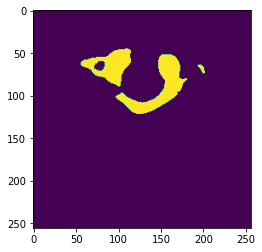

In [116]:
plt.imshow(targets[3][0][:, :, 31])

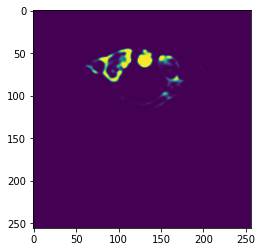

In [115]:
plt.imshow(outputs[3][0][:, :, 31])

In [21]:
def test_one_epoch(path, loader, running_dist=True, debug=False, do_ema=True):
    model = Model(pretrained=False)
    st = torch.load(path, map_location=f"cpu")
    model.eval()
    model.cuda()
    model.load_state_dict(st, strict=False)
    
    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    running_loss = 0.
    
    OUTPUTS, TARGETS, IDS = [], [], []
    
    for step, data in enumerate(bar):
        
        with torch.no_grad():
            images = data['images'].cuda()
            targets = data['labels'].cuda()
            #targets_masks = data['masks'].cuda()
            ids = data['ids']
            
            with torch.cuda.amp.autocast(enabled=CFG.autocast):
                if do_ema:
                    with ema.average_parameters():
                        logits, logits_mask = model(images)
                else:
                    logits, logits_mask = model(images)
                
            return logits, logits_mask
                
            outputs = logits.float().detach().cpu().numpy()
            targets = targets.float().detach().cpu().numpy()
            #outputs = logits_mask.float().sigmoid().detach().cpu()#.numpy()
            #targets = targets_masks.float().detach().cpu()#.numpy()
            
            #'''
            if running_dist:
                dist.barrier()
                
                np.save(f'{CFG.cache_dir}/preds_{get_rank()}.npy', outputs)
                np.save(f'{CFG.cache_dir}/targets_{get_rank()}.npy', targets)
                np.save(f'{CFG.cache_dir}/ids_{get_rank()}.npy', ids)
                
                dist.barrier()
                
                if is_main_process():
                    outputs = np.concatenate([np.load(f"{CFG.cache_dir}/preds_{_}.npy") for _ in range(CFG.N_GPUS)])
                    targets = np.concatenate([np.load(f"{CFG.cache_dir}/targets_{_}.npy") for _ in range(CFG.N_GPUS)])
                    ids = np.concatenate([np.load(f"{CFG.cache_dir}/ids_{_}.npy") for _ in range(CFG.N_GPUS)])
                    
                dist.barrier()
            else:    
                pass
            
            OUTPUTS.extend(outputs)
            TARGETS.extend(targets)
            IDS.extend(ids)
            #'''
            
            #if step==10: break
            
    if running_dist:
        dist.barrier()
    
    if is_main_process():
        OUTPUTS = np.stack(OUTPUTS)#[:, :6]
        TARGETS = np.stack(TARGETS)#[:, :6]
        IDS = np.stack(IDS)
        
        #return OUTPUTS, TARGETS, IDS
        
        score = np.mean(np.abs(OUTPUTS-TARGETS))
        
        print(f"EPOCH {CFG.epoch+1} | MAE {score}")
    
        if debug:
            return score, OUTPUTS, TARGETS, IDS
    
        return score
    
    if debug:
        return [], [], [], []

In [39]:
logits, logits_mask = test_one_epoch('./data/AAA_SEG/TRY1_SEG/tf_efficientnetv2_s.in21k_ft_in1k_v2/3_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

0/104 00:00<? 


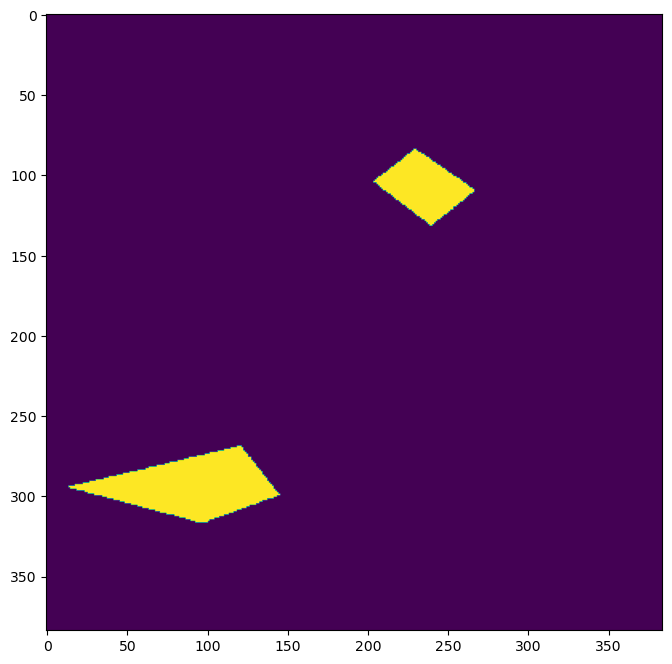

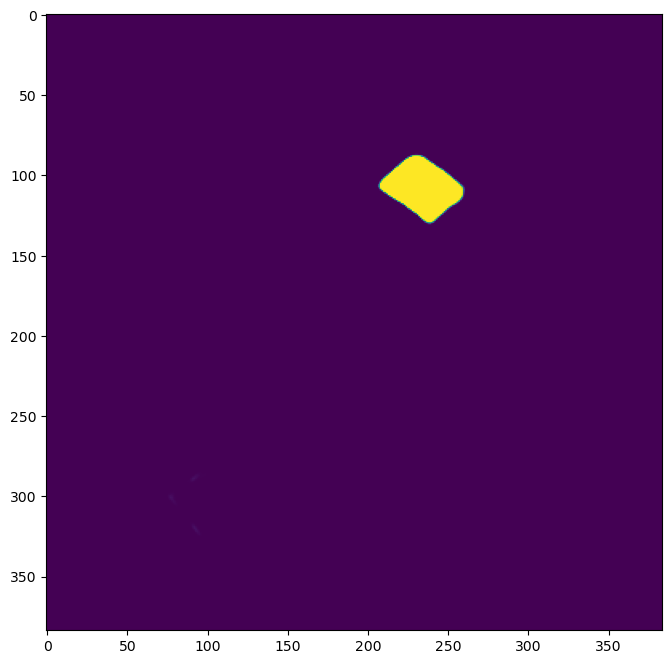

In [46]:
x = 5
plt.imshow(d['masks'][x][1]); plt.show()
plt.imshow(logits_mask.sigmoid()[x][1].detach().cpu()); plt.show()

In [22]:
score, OUTPUTS, TARGETS, IDS = test_one_epoch('./data/AAA_SEG/TRY1_SEG/tf_efficientnetv2_s.in21k_ft_in1k_v1/0_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

0/104 00:00<? 


ValueError: not enough values to unpack (expected 4, got 2)

In [100]:
np.abs(np.round(OUTPUTS[:, 0]) - TARGETS[:, 0]).mean()

0.17028986

In [99]:
np.abs(np.round(OUTPUTS[:, 1]) - TARGETS[:, 1]).mean()

3.607488

In [104]:
np.abs(TARGETS[:, 0].mean() - TARGETS[:, 0]).mean()

0.42340544

In [105]:
np.abs(TARGETS[:, 1].mean() - TARGETS[:, 1]).mean()

6.549333

In [95]:
np.round(OUTPUTS[:, 1], 0)

array([ 1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,  4.,  0.,  1.,  2.,
        1.,  2.,  1.,  1.,  2.,  2.,  0.,  4.,  1.,  7.,  3.,  1.,  2.,
        3.,  1.,  1.,  2.,  0.,  4.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,
        0.,  1.,  1.,  2.,  1.,  0.,  2.,  3.,  1.,  2.,  3.,  1.,  2.,
        1.,  2.,  1.,  1.,  1.,  1.,  2.,  1., 11.,  1.,  1.,  1.,  2.,
        1.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  3.,  1.,  1.,
        1.,  1.,  0.,  6.,  1.,  1.,  0.,  3.,  1.,  1., 48.,  1.,  0.,
        1.,  1.,  0.,  1.,  3.,  2.,  1.,  2.,  7.,  1.,  2.,  2.,  1.,
        1.,  0.,  1.,  3.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,
        5.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,
        2.,  2.,  1.,  4.,  2.,  1.,  1.,  2.,  1.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  1.,  3.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,
        5.,  8.,  3.,  1.,  6.,  4.,  0.,  1.,  1.,  3.,  2.,  2.,  2.,
        1.,  1.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  5.,  1.,  0

In [93]:
TARGETS[:, 1]

array([  2.,   1.,   1.,   5.,   1.,   2.,   1.,   1.,   2.,   1., 174.,
         1.,   2.,   1.,   2.,   1.,   3.,   2.,   1.,   0.,   2.,   1.,
        14.,   6.,   2.,   1.,   4.,   1.,   1.,   2.,   0.,   4.,   0.,
         1.,   2.,   2.,   2.,   4.,   2.,   0.,   1.,   1.,   3.,   6.,
         0.,   4.,   4.,   1.,   1.,   5.,   1.,   3.,   2.,   2.,   1.,
         2.,   1.,   1.,   1.,   2.,  18.,   1.,   1.,   1.,   3.,   2.,
         2.,   5.,   1.,   2.,   1.,   2.,   1.,   2.,   1.,  18.,   1.,
         1.,   1.,   2.,   0.,  12.,   2.,   1.,   0.,  13.,   1.,   1.,
       171.,   1.,   6.,   2.,   1.,   0.,   1.,   5.,   2.,   2.,   2.,
        17.,   4.,  32.,   3.,   1.,   2.,   0.,   2.,   6.,   1.,   2.,
         2.,   5.,   2.,   0.,   1.,   0.,   3.,   7.,   8.,   1.,   3.,
         2.,   5.,   1.,   3.,   1.,   0.,   4.,   2.,   4.,   2.,   2.,
         2.,   4.,   3.,   1.,   1.,   2.,   1.,   0.,   1.,   1.,   1.,
         7.,   1.,  10.,   0.,   3.,   5.,   1.,   

In [82]:
TARGETS[:, 1].mean()

5.5519323

In [20]:
score, OUTPUTS, TARGETS, IDS = test_one_epoch('./data/AAA_CLS/TRY1_CLS/tf_efficientnetv2_s.in21k_ft_in1k_v2/0_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

86/86 00:04<00:00 

EPOCH 1 | AUC 0.9988291900561347


In [26]:
OUTPUTS[TARGETS==0]

array([5.40763059e-11, 2.59097945e-03, 2.60703091e-05, 7.42638076e-05,
       5.29661384e-06, 1.83428929e-05, 2.47727172e-07, 1.78131129e-04,
       9.61024198e-05, 3.87476146e-04, 9.62564215e-08, 2.04203320e-06,
       2.79693013e-05, 2.25558182e-07, 1.30329747e-04, 7.62598110e-11,
       8.53032088e-06, 1.34404097e-08, 6.47594788e-07, 2.62747726e-05,
       9.62212624e-04, 4.57539136e-05, 1.35743306e-07, 9.11051175e-04,
       1.47924666e-07, 1.27787280e-06, 5.91419979e-13, 6.24093036e-06,
       2.21256687e-05, 6.21478264e-08, 9.06971912e-14, 1.21130643e-03,
       1.66139065e-03, 4.13353991e-05, 3.07743088e-04, 1.05432015e-12,
       2.52682275e-05, 4.40011863e-05, 9.02803804e-05, 6.25371322e-05,
       1.81408182e-01, 1.67014205e-05, 3.33656307e-14, 9.57675397e-01,
       2.78030959e-04, 5.44213282e-04, 1.79179879e-05, 1.08451673e-06,
       4.03779013e-05, 7.06640072e-03, 1.47389828e-05, 6.64104824e-04,
       1.92602864e-04, 9.18485270e-08, 8.99096108e-07, 1.32381858e-04,
      

In [25]:
np.sum(TARGETS==0, 0)

array([186, 285, 515])

In [37]:
TARGETS[(TARGETS[:, 0]==0) & (TARGETS[:, 2]!=1.)]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [35]:
TARGETS[(TARGETS[:, 1]==0) & (TARGETS[:, 2]!=1.)]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [42]:
np.round(OUTPUTS[(TARGETS[:, 0]==0) & (TARGETS[:, 2]!=1.)], 3)

array([[0.958, 1.   , 0.   ],
       [0.925, 0.997, 0.001],
       [0.702, 0.999, 0.005],
       [0.892, 0.998, 0.003],
       [0.921, 0.995, 0.002],
       [0.85 , 1.   , 0.001],
       [0.923, 0.999, 0.001],
       [0.944, 1.   , 0.   ],
       [0.922, 1.   , 0.   ],
       [0.954, 1.   , 0.   ],
       [0.891, 1.   , 0.002],
       [0.868, 1.   , 0.001],
       [0.899, 0.942, 0.009],
       [1.   , 0.999, 0.   ]], dtype=float32)

In [58]:
np.round(OUTPUTS[(TARGETS[:, 1]==0) & (TARGETS[:, 2]!=1.)], 3)

array([[1.   , 0.   , 0.   ],
       [1.   , 0.181, 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.992, 0.286, 0.001],
       [0.998, 0.239, 0.   ],
       [0.981, 0.6  , 0.002],
       [0.992, 0.229, 0.001],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.995, 0.161, 0.001],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.001, 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.999, 0.168, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.

In [21]:
OUTPUTS[TARGETS==1]

array([0.9999733 , 1.        , 0.7049733 , ..., 0.9999286 , 0.99997854,
       0.9999826 ], dtype=float32)